In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

#### Loading model metrics from Data Dynamics

In [2]:
model_name = "LaBSE"
# based on logs from classify/train_model/logs/training_dynamics
metrics_path = "../../models/td_metrics.jl"
td_metrics = pd.read_json(metrics_path, orient="records", lines=True)

#### Ploting cartography

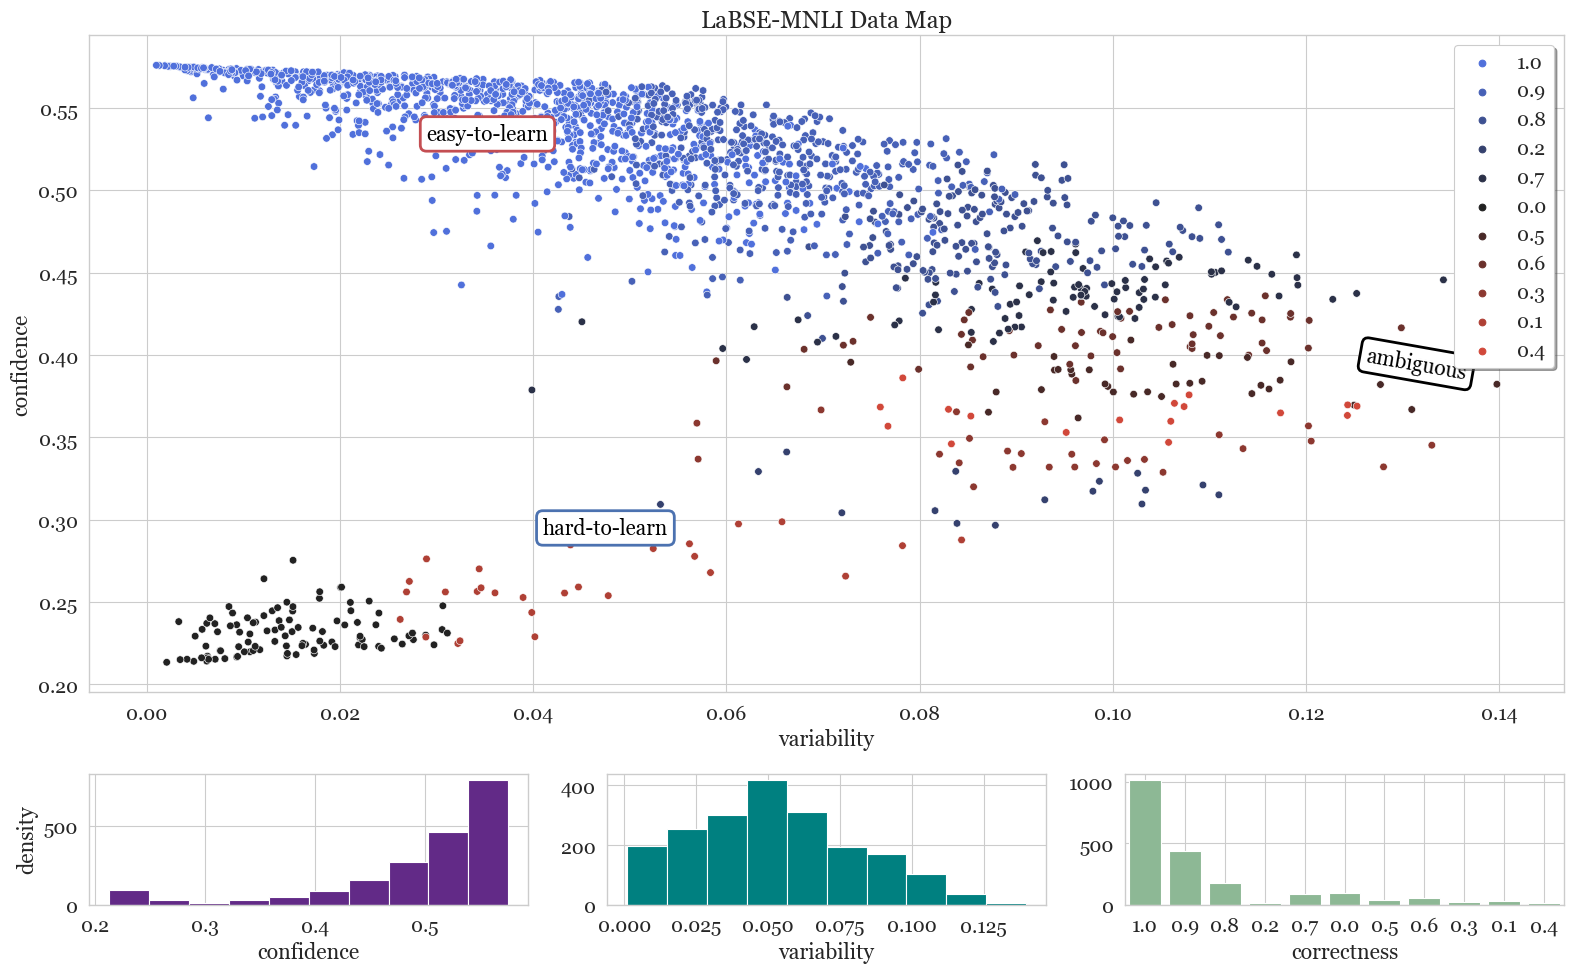

In [3]:
def scatter_it(dataframe, hue_metric ='correct.', title='', model='RoBERTa', show_hist=False):
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
        ax0 = fig.add_subplot(gs[0, :])
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)
    
    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", rotation=350, bbox=bb('black'))
    an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('r'))
    an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')
    
    if show_hist:
        plot.set_title(f"{model}-{title} Data Map", fontsize=17)
        
        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')

        plot2 = sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3)
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('')

    fig.tight_layout()
    filename = f'./figures/cartography_{title}_{model}.pdf' if show_hist else f'./figures/cartography_compact_{title}_{model}.pdf'
    fig.savefig(filename, dpi=300)

scatter_it(td_metrics, title='MNLI', model='LaBSE', show_hist=True)

#### Analyzing data

In [4]:
data = pd.read_csv(f'../../data/sample_with_target.tsv', sep='\t')
data = data.rename(columns={'id':'id_str'})
data['id_str'] = data['id_str'].astype(str)

##### Ambiguous tweets

In [ ]:
ambiguous = td_metrics.nsmallest(10, 'variability')['guid'].values.tolist()
data[data["id_str"].isin(ambiguous)]["full_text"]

##### Easy tweets

In [ ]:
easy = td_metrics.nlargest(10, 'confidence')['guid'].values.tolist()
data[data["id_str"].isin(easy)]["full_text"]

##### Hard tweets

In [ ]:
hard = td_metrics.nsmallest(10, 'confidence')['guid'].values.tolist()
data[data["id_str"].isin(hard)]["full_text"]